In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip "/content/drive/MyDrive/train_aug.zip" -d "/content/data"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/train_aug/possum/possum_3_aug3.jpg  
  inflating: /content/data/train_aug/possum/possum_40_aug0.jpg  
  inflating: /content/data/train_aug/possum/possum_40_aug1.jpg  
  inflating: /content/data/train_aug/possum/possum_40_aug2.jpg  
  inflating: /content/data/train_aug/possum/possum_40_aug3.jpg  
  inflating: /content/data/train_aug/possum/possum_41_aug0.jpg  
  inflating: /content/data/train_aug/possum/possum_41_aug1.jpg  
  inflating: /content/data/train_aug/possum/possum_41_aug2.jpg  
  inflating: /content/data/train_aug/possum/possum_41_aug3.jpg  
  inflating: /content/data/train_aug/possum/possum_42_aug0.jpg  
  inflating: /content/data/train_aug/possum/possum_42_aug1.jpg  
  inflating: /content/data/train_aug/possum/possum_42_aug2.jpg  
  inflating: /content/data/train_aug/possum/possum_42_aug3.jpg  
  inflating: /content/data/train_aug/possum/possum_43_aug0.jpg  
  inflating: /content/data/train_aug/pos

In [8]:
!pip install transformers datasets torchvision

In [9]:
# Optimize edilebilirler.
batch_size = 32
num_epochs = 100
learning_rate = 3e-5
dropout_rate = 0.1
patience = 5
best_val_loss = float("inf")
counter = 0

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

data_dir = "/content/data/train_aug"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# PIL görüntüsünü → PyTorch’un Tensor tipine çevirir
# Aynı zamanda [0, 255] → [0.0, 1.0] normalizasyonu uygular
# Örn.
# Bir görselin piksel değeri 128 ise → 0.5019 gibi bir float olur.

dataset = datasets.ImageFolder(data_dir, transform=transform)

from torch.utils.data import random_split

total_size = len(dataset)
train_size = int(0.64 * len(dataset))
val_size = int(0.16 * len(dataset))
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

class_names = dataset.classes

In [11]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

model_name = "facebook/deit-base-patch16-224"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=len(class_names),
    ignore_mismatched_sizes=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([90, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([90]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from tqdm.notebook import tqdm
import torch
from torch import nn, optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
val_accuracies = []

best_val_loss = float("inf")
counter = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(pixel_values=images).logits
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    acc = correct / total

    train_losses.append(total_loss)
    val_losses.append(val_loss)
    val_accuracies.append(acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {acc:.2%}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "deit_base_model.pt")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early Stopping activated.")
            break

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 1/100 | Train Loss: 564.4519 | Val Loss: 0.1982 | Val Acc: 98.49%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 2/100 | Train Loss: 28.2862 | Val Loss: 0.0565 | Val Acc: 99.41%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 3/100 | Train Loss: 6.8114 | Val Loss: 0.0313 | Val Acc: 99.71%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 4/100 | Train Loss: 3.1024 | Val Loss: 0.0231 | Val Acc: 99.74%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 5/100 | Train Loss: 1.8400 | Val Loss: 0.0194 | Val Acc: 99.71%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 6/100 | Train Loss: 1.2327 | Val Loss: 0.0177 | Val Acc: 99.71%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 7/100 | Train Loss: 0.8779 | Val Loss: 0.0162 | Val Acc: 99.71%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 8/100 | Train Loss: 0.6485 | Val Loss: 0.0153 | Val Acc: 99.71%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 9/100 | Train Loss: 0.4918 | Val Loss: 0.0147 | Val Acc: 99.71%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 10/100 | Train Loss: 0.3805 | Val Loss: 0.0144 | Val Acc: 99.71%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 11/100 | Train Loss: 0.2987 | Val Loss: 0.0142 | Val Acc: 99.71%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 12/100 | Train Loss: 0.2372 | Val Loss: 0.0137 | Val Acc: 99.71%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 13/100 | Train Loss: 0.1901 | Val Loss: 0.0136 | Val Acc: 99.71%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 14/100 | Train Loss: 0.1536 | Val Loss: 0.0134 | Val Acc: 99.71%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 15/100 | Train Loss: 0.1247 | Val Loss: 0.0134 | Val Acc: 99.67%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 16/100 | Train Loss: 0.1019 | Val Loss: 0.0134 | Val Acc: 99.67%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 17/100 | Train Loss: 0.0835 | Val Loss: 0.0136 | Val Acc: 99.67%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 18/100 | Train Loss: 0.0687 | Val Loss: 0.0134 | Val Acc: 99.64%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 19/100 | Train Loss: 0.0568 | Val Loss: 0.0137 | Val Acc: 99.64%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 20/100 | Train Loss: 0.0470 | Val Loss: 0.0137 | Val Acc: 99.64%


  0%|          | 0/382 [00:00<?, ?it/s]

Epoch 21/100 | Train Loss: 0.0390 | Val Loss: 0.0137 | Val Acc: 99.61%
Early Stopping activated.


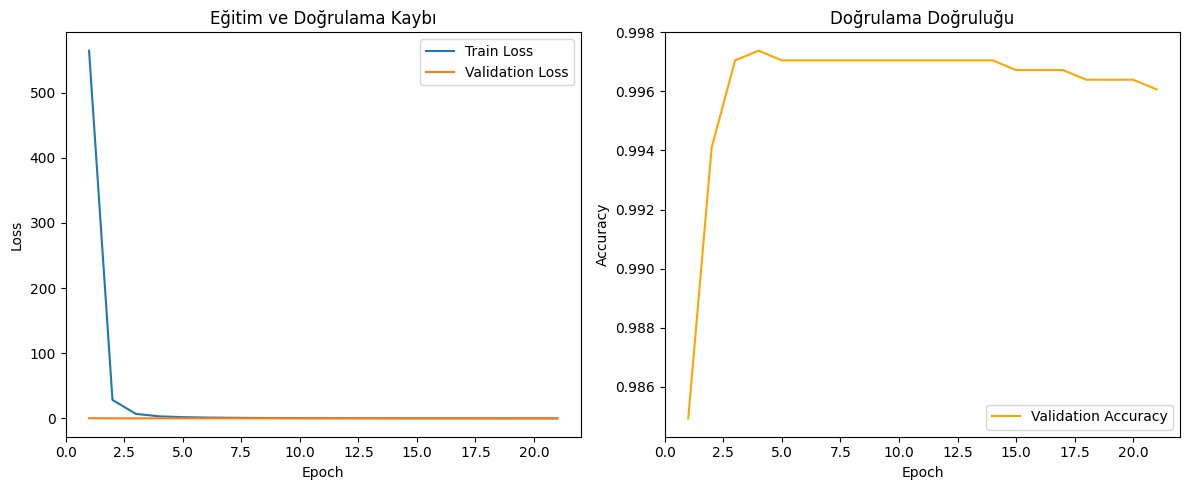

In [13]:
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Eğitim ve Doğrulama Kaybı")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Doğrulama Doğruluğu")
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
model.load_state_dict(torch.load("deit_base_model.pt"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(pixel_values=images).logits
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print("\n--- Test Set Classification Metrics ---")
print(f"Accuracy : %{accuracy * 100:.3f}")
print(f"Precision: %{precision * 100:.3f}")
print(f"Recall   : %{recall * 100:.3f}")
print(f"F1-Score : %{f1 * 100:.3f}")

print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


--- Test Set Classification Metrics ---
Accuracy : %99.659
Precision: %99.624
Recall   : %99.614
F1-Score : %99.610

Detailed Classification Report:
                precision    recall  f1-score   support

      antelope       1.00      0.97      0.98        33
        badger       1.00      1.00      1.00        38
           bat       0.98      1.00      0.99        41
          bear       1.00      1.00      1.00        30
           bee       1.00      1.00      1.00        46
        beetle       1.00      1.00      1.00        43
         bison       1.00      1.00      1.00        42
          boar       1.00      1.00      1.00        43
     butterfly       1.00      1.00      1.00        44
           cat       1.00      1.00      1.00        39
   caterpillar       0.94      1.00      0.97        31
    chimpanzee       1.00      0.95      0.97        37
     cockroach       1.00      1.00      1.00        57
           cow       1.00      1.00      1.00        36
        c

In [17]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
print(f"Doğruluk (Accuracy): %{accuracy * 100:.2f}")

Doğruluk (Accuracy): %99.66


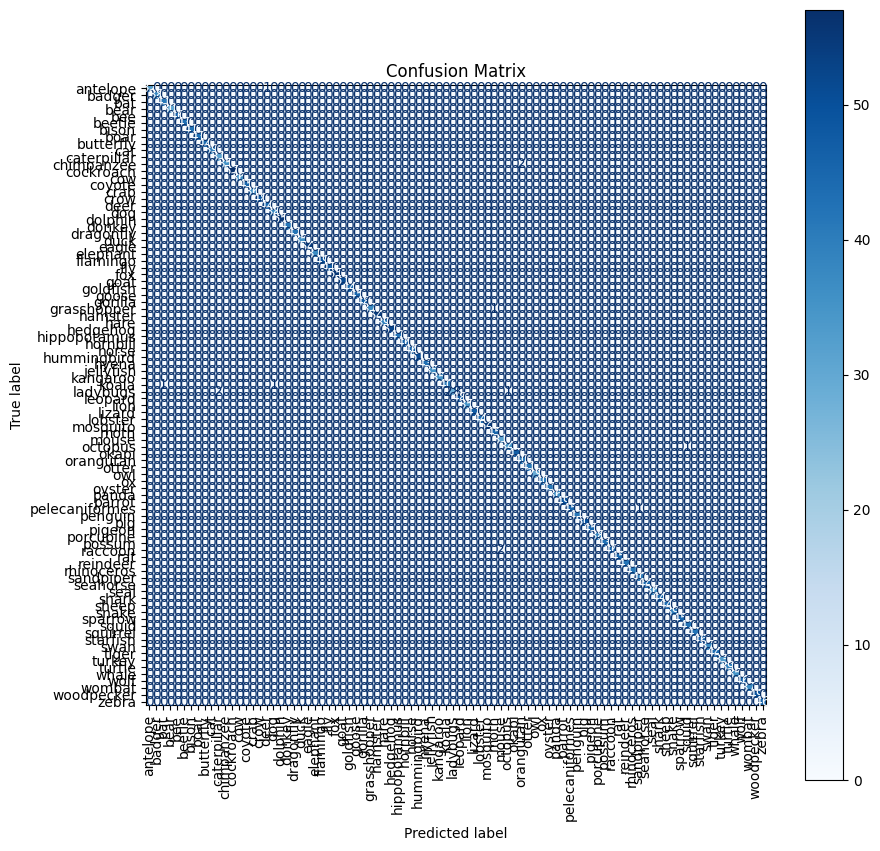

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap="Blues", xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()